In [17]:
# import required packages

import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sb
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

import sklearn
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler

from subprocess import check_output
import time #helper libraries

import math

import datetime

import os

import tensorflow as tf
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.rnn as rnn

import random

In [2]:
#Import S&P 500 file and keep only 'Close' values. Drop other columns
snp = pd.read_csv('HistoricalPrices.csv')
print (snp.head())
snp.drop(['Open', 'High', 'Low'], axis=1,inplace=True)
snp.head()

         Date     Open     High      Low    Close
0  2018-04-02  2633.45  2638.30  2553.80  2581.88
1  2018-03-29  2614.41  2659.07  2609.72  2640.87
2  2018-03-28  2611.30  2632.65  2593.06  2605.00
3  2018-03-27  2667.57  2674.78  2596.12  2612.62
4  2018-03-26  2619.35  2661.36  2601.81  2658.55


,Date,Close
0,2018-04-02,2581.88
1,2018-03-29,2640.87
2,2018-03-28,2605.00
3,2018-03-27,2612.62
4,2018-03-26,2658.55


In [3]:
# Import gdp data
gdp = pd.read_csv('GDP Historical Data.csv')
print (gdp.head())
gdp.head()

         Date      Value
0  2017-09-30  17163.894
1  2017-06-30  17031.085
2  2017-03-31  16903.240
3  2016-12-31  16851.420
4  2016-09-30  16778.148


,Date,Value
0,2017-09-30,17163.894
1,2017-06-30,17031.085
2,2017-03-31,16903.240
3,2016-12-31,16851.420
4,2016-09-30,16778.148


In [4]:
#Convert date to Index
snp.Date = pd.to_datetime(snp.Date)
snp.set_index('Date', inplace=True)
snp.head()

,Close
Date,
2018-04-02,2581.88
2018-03-29,2640.87
2018-03-28,2605.00
2018-03-27,2612.62
2018-03-26,2658.55


In [5]:
#Convert date to Index
gdp.Date = pd.to_datetime(gdp.Date)
gdp.set_index('Date', inplace=True)
gdp.head()

,Value
Date,
2017-09-30,17163.894
2017-06-30,17031.085
2017-03-31,16903.240
2016-12-31,16851.420
2016-09-30,16778.148


In [6]:
# Set in Increasing Order
snp.sort_index(ascending=True, inplace=True)
snp.head()

,Close
Date,
1995-01-03,459.11
1995-01-04,460.71
1995-01-05,460.34
1995-01-06,460.68
1995-01-09,460.83


In [7]:
# Set in Increasing Order
gdp.sort_index(ascending=True, inplace=True)
gdp.head()

,Value
Date,
1995-06-30,10122.122
1995-09-30,10208.772
1995-12-31,10281.246
1996-03-31,10348.691
1996-06-30,10529.379


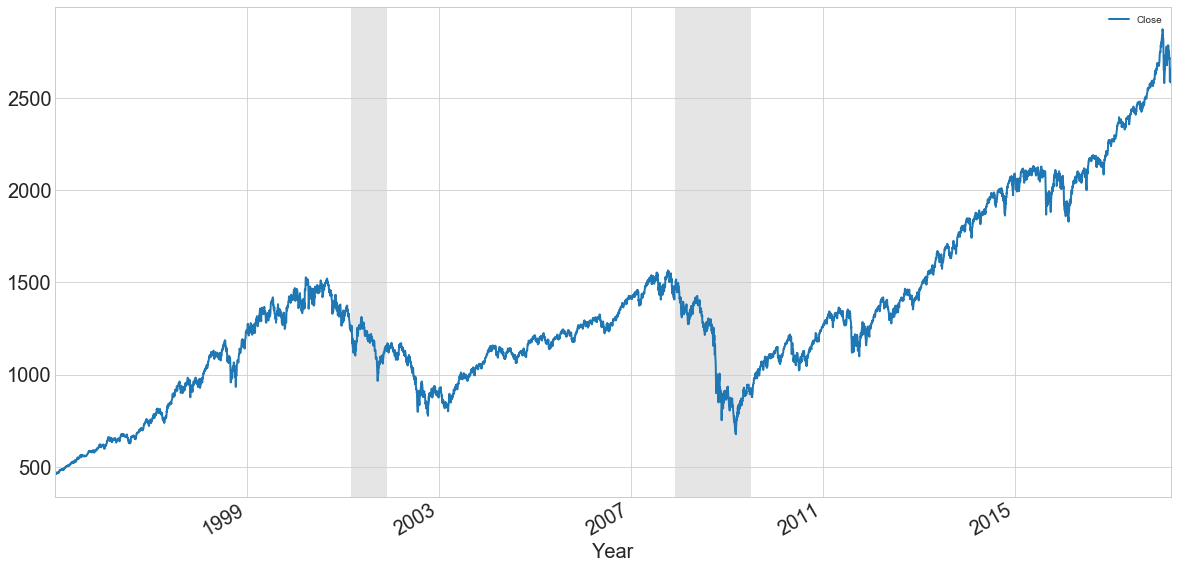

In [8]:
# Plot S&P Data
snp.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.axvspan('2001-03-01', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-01', '2009-06-30', facecolor='0.8', alpha = 0.5)
plt.savefig('snp_daily.jpeg',format ='jpeg')

In [9]:
# Convert S&P daily  to S&P Weekly
Close = snp.Close.resample('W-MON', how='last')
weekly_data = pd.DataFrame(Close)
weekly_data.head()

,Close
Date,
1995-01-09,460.83
1995-01-16,469.38
1995-01-23,465.81
1995-01-30,468.51
1995-02-06,481.14


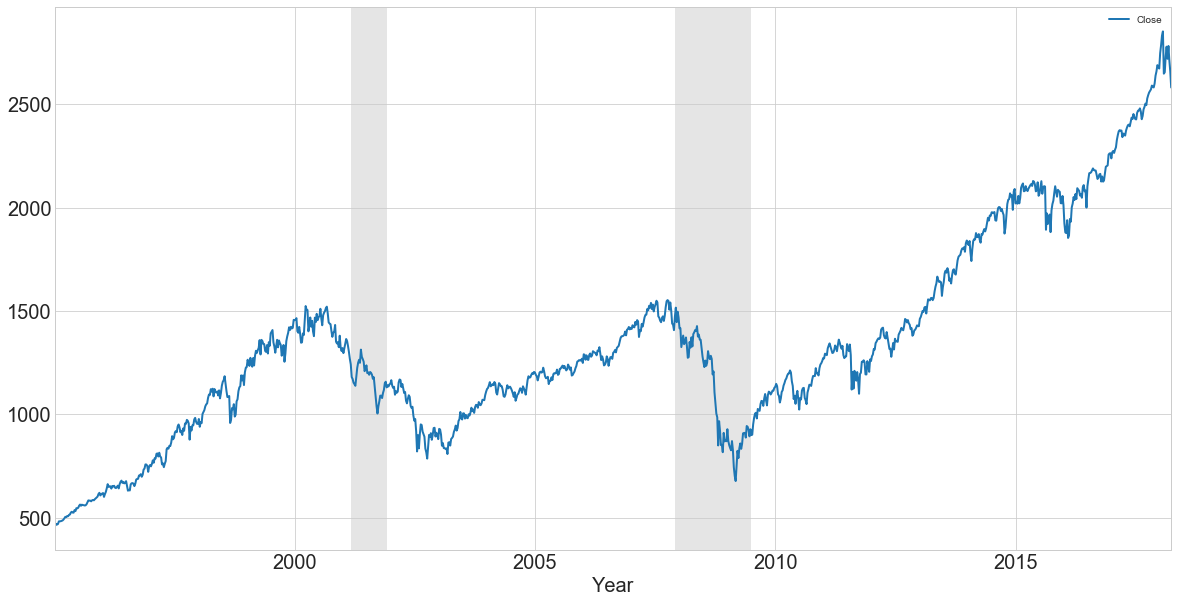

In [10]:
# Plot Weekly data
weekly_data.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.axvspan('2001-03-01', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-01', '2009-06-30', facecolor='0.8', alpha = 0.5)


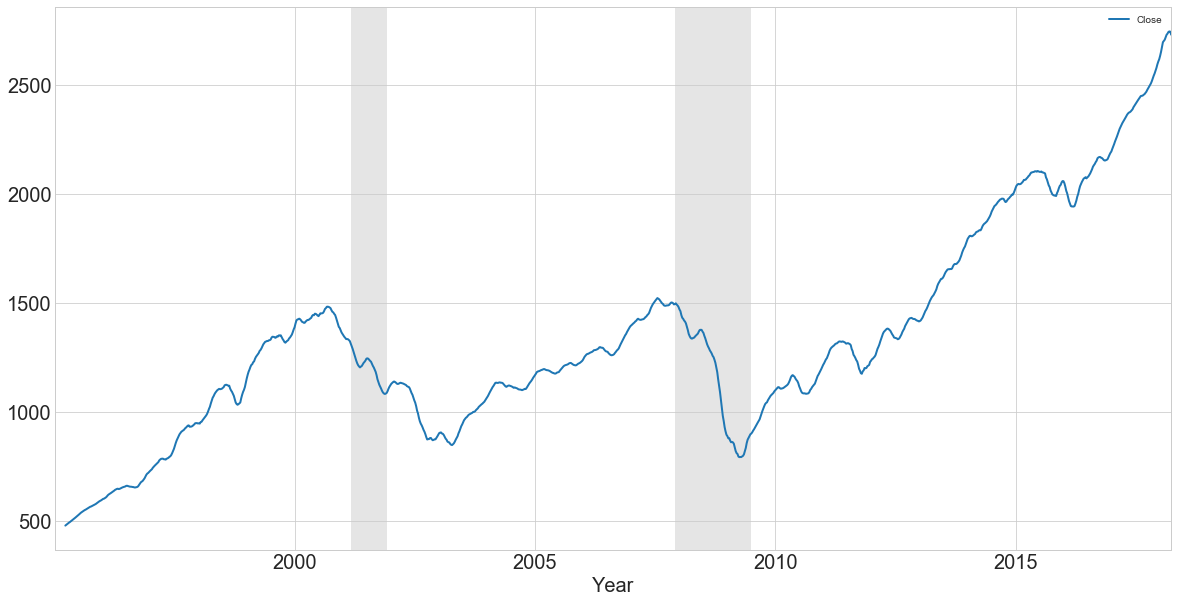

In [11]:
# Rolling average of weekly data using 12 weeks
Price = weekly_data[['Close']]
Price.rolling(12).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.axvspan('2001-03-01', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-01', '2009-06-30', facecolor='0.8', alpha = 0.5)
plt.xlabel('Year', fontsize=20);

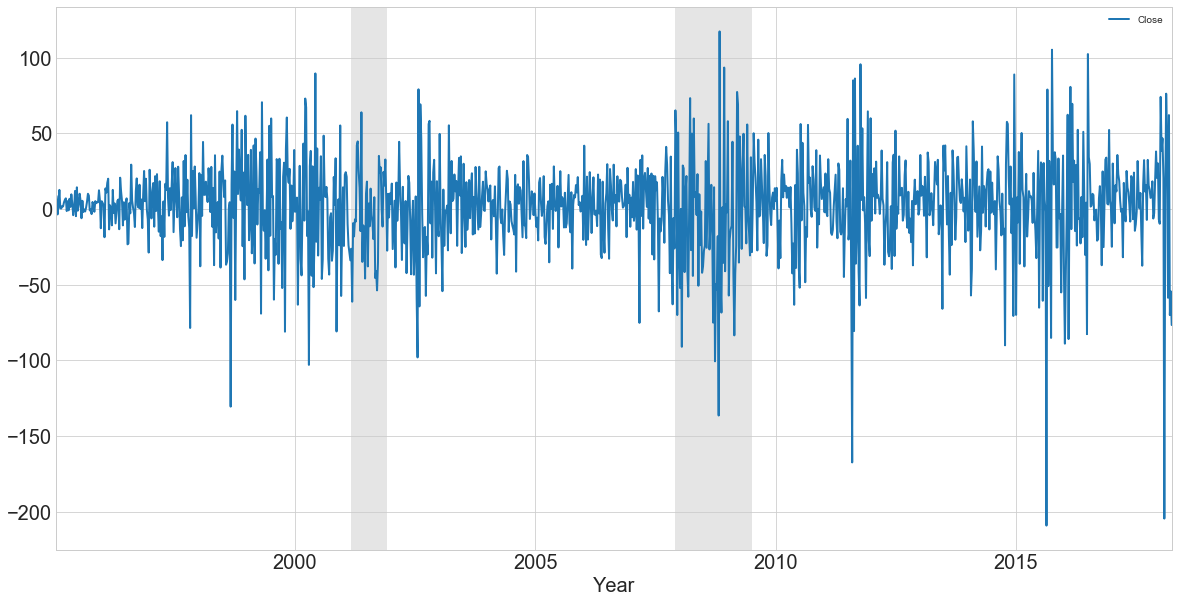

In [10]:
# First order difference of weekly data
Order1_Price = Price.diff()
Order1_Price.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.axvspan('2001-03-01', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-01', '2009-06-30', facecolor='0.8', alpha = 0.5)
plt.xlabel('Year', fontsize=20);

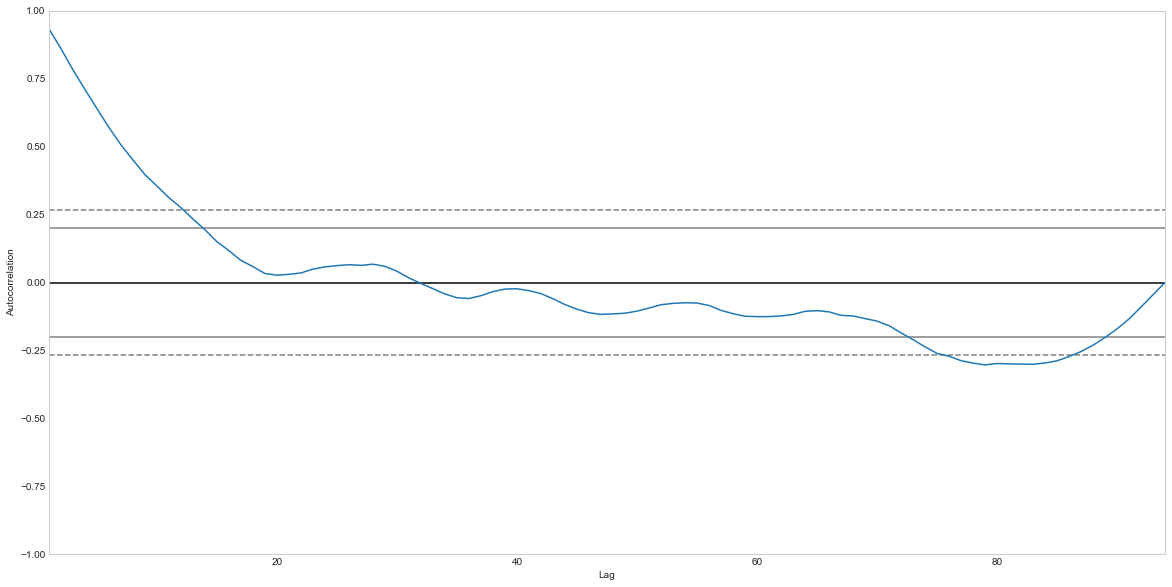

In [35]:
# Auto correlation of weekly data
pd.plotting.autocorrelation_plot(Price);
plt.savefig('AutoCorrelation.jpeg',format ='jpeg')

In [12]:
# Convert s&p daily to quarterly
Close = snp.Close.resample('Q', how='last')
quarterly_data = pd.DataFrame(Close)
quarterly_data.head()

,Close
Date,
1995-03-31,500.71
1995-06-30,544.75
1995-09-30,584.41
1995-12-31,615.93
1996-03-31,645.50


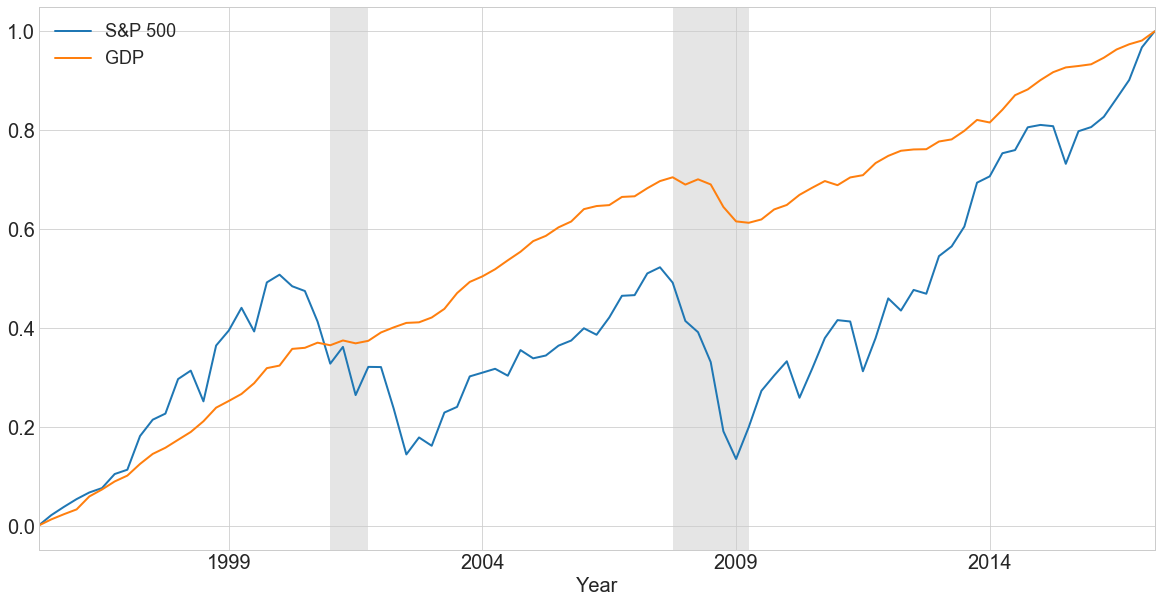

In [13]:
# Normalise S&P quarterly and gdp  to fall in to same scale and plot them.
concat = pd.concat([quarterly_data,gdp],axis=1)
from sklearn import preprocessing

#x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(concat.iloc[1:-4,:])
df = pd.DataFrame(x_scaled)
df = df.set_index(concat.index.values[1:-4])


df.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.axvspan('2001-03-31', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-31', '2009-06-30', facecolor='0.8', alpha = 0.5)
plt.legend(['S&P 500','GDP'], fontsize=18)

plt.savefig('snp_qtrly vs gdp.jpeg',format ='jpeg')

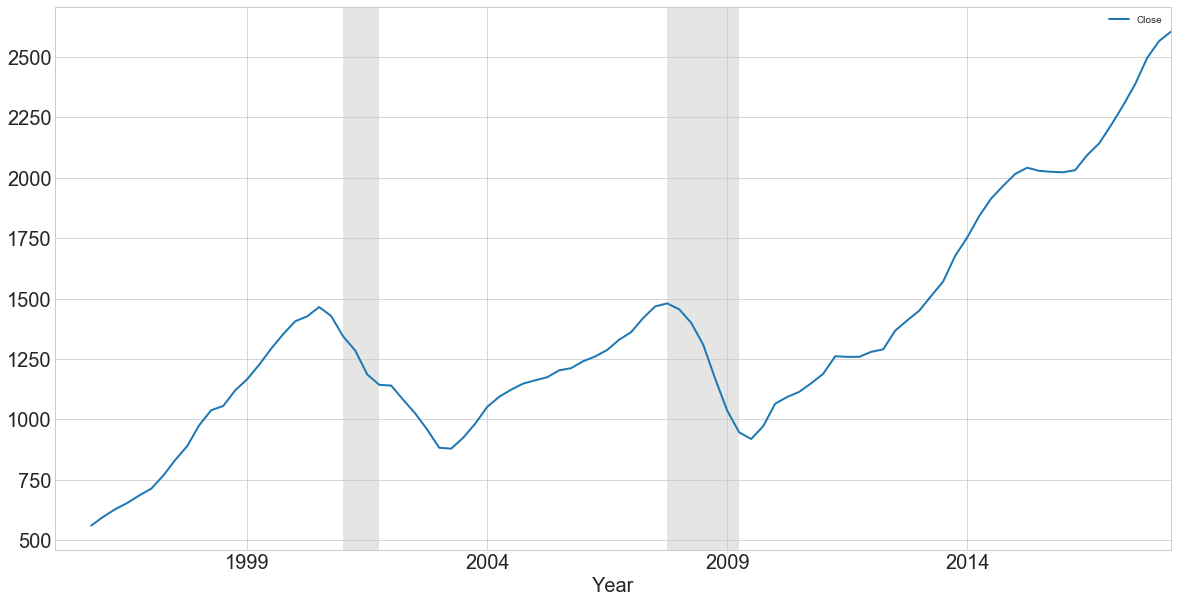

In [14]:
# Rolling average of s&p quarterly using 4 quarters
Price = quarterly_data[['Close']]
Price.rolling(4).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.axvspan('2001-03-01', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-01', '2009-06-30', facecolor='0.8', alpha = 0.5)
plt.xlabel('Year', fontsize=20);

plt.savefig('snp_trend.jpeg',format ='jpeg')

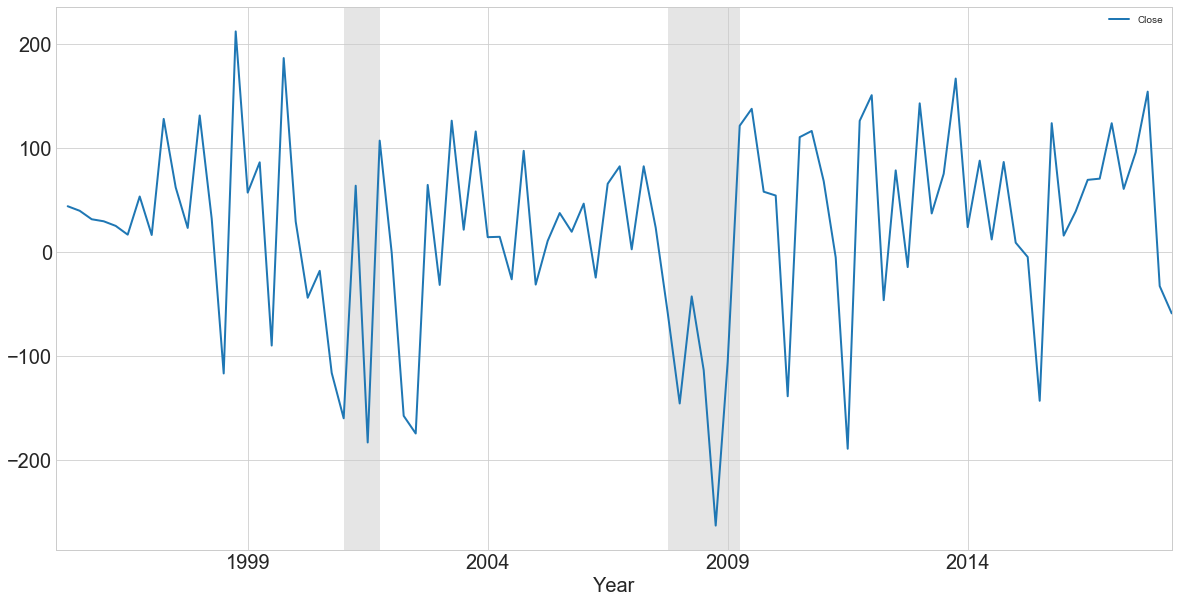

In [15]:
# 1st order difference plot
Order1_Price = Price.diff()
Order1_Price.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.axvspan('2001-03-01', '2001-11-30', facecolor='0.8', alpha = 0.5)
plt.axvspan('2007-12-01', '2009-06-30', facecolor='0.8', alpha = 0.5)
plt.xlabel('Year', fontsize=20);
plt.savefig('Stationarity.jpeg',format ='jpeg')

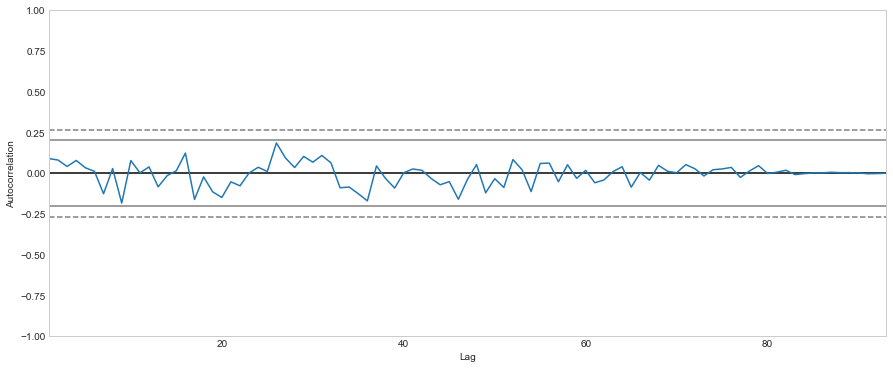

In [18]:
# Auto-correlation of 1st oredr differnce
pd.plotting.autocorrelation_plot(Order1_Price[1:]);
plt.savefig('AutoCorr_Order1.jpeg',format ='jpeg')

In [19]:
# data prep for RNN
test_set_size_percentage = 20
# function to create train, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [20]:
seq_len = 20
x_train, y_train, x_test, y_test = load_data(quarterly_data,seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (59, 19, 1)
y_train.shape =  (59, 1)
x_test.shape =  (15, 19, 1)
y_test.shape =  (15, 1)


In [21]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [22]:
# parameters
n_steps = seq_len-1 
n_inputs = 1
n_neurons = 500
n_outputs = 1
n_layers = 1
learning_rate = 0.001
batch_size = 20
n_epochs = 200
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
         for layer in range(n_layers)]

#use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            print('%.2f epochs: MSE train = %.6f'%(iteration*batch_size/train_set_size, mse_train))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train = 989369.500000
4.75 epochs: MSE train = 26488.781250
9.49 epochs: MSE train = 19434.822266
14.24 epochs: MSE train = 17853.083984
18.98 epochs: MSE train = 16481.513672
23.73 epochs: MSE train = 15388.743164
28.47 epochs: MSE train = 14447.197266
33.22 epochs: MSE train = 13444.976562
37.97 epochs: MSE train = 12865.232422
42.71 epochs: MSE train = 13447.148438
47.46 epochs: MSE train = 13495.404297
52.20 epochs: MSE train = 14139.453125
56.95 epochs: MSE train = 11043.350586
61.69 epochs: MSE train = 8665.609375
66.44 epochs: MSE train = 9140.671875
71.19 epochs: MSE train = 19906.148438
75.93 epochs: MSE train = 11307.723633
80.68 epochs: MSE train = 8492.831055
85.42 epochs: MSE train = 9670.118164
90.17 epochs: MSE train = 8410.223633
94.92 epochs: MSE train = 6292.794922
99.66 epochs: MSE train = 8302.491211
104.41 epochs: MSE train = 9168.291992
109.15 epochs: MSE train = 7875.198242
113.90 epochs: MSE train = 5641.095703
118.64 epochs: MSE train = 5123.39

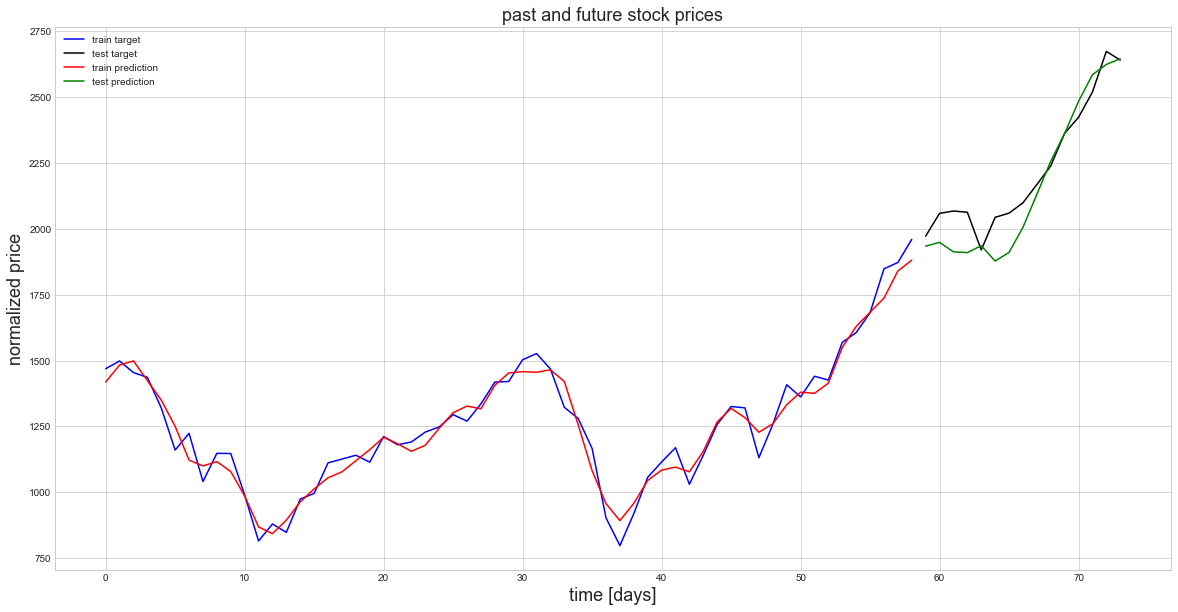

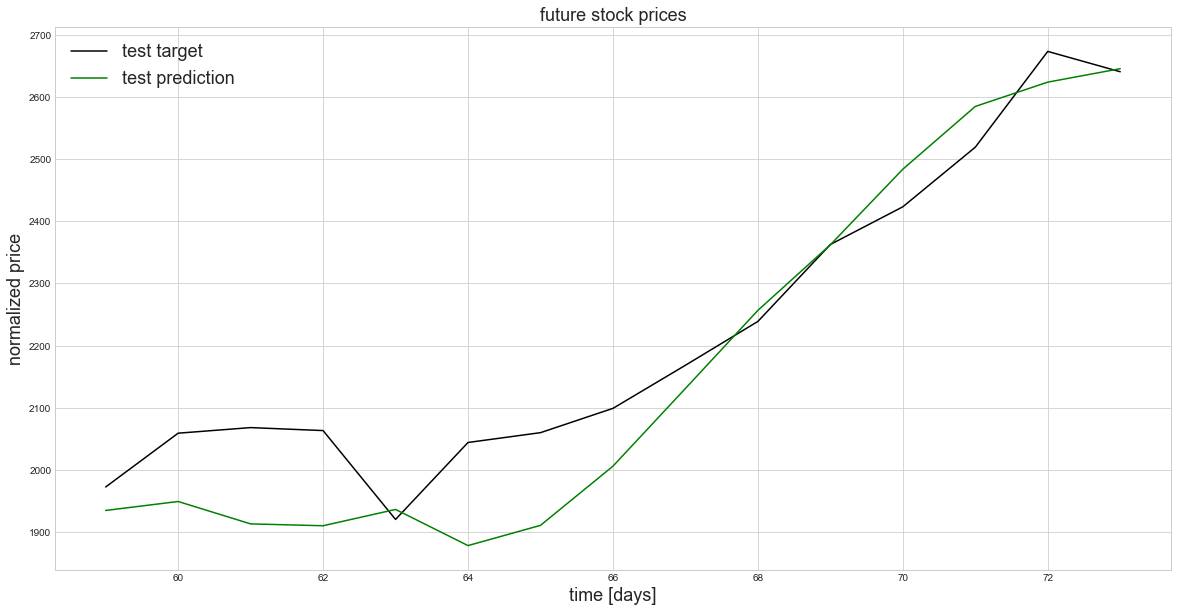

correct sign prediction for close price for train/test: 0.00/1.00


In [23]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
#plt.figure(figsize=(15, 5));
#plt.subplot(1,2,1);
rcParams['figure.figsize'] = 20, 10

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')


plt.plot(np.arange(y_train.shape[0],
                   y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')


plt.plot(np.arange(y_train_pred.shape[0],
                   y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices', fontsize=18)
plt.xlabel('time [days]', fontsize=18)
plt.ylabel('normalized price', fontsize=18)
plt.legend(loc='best');
plt.savefig('past&future.jpeg',format ='jpeg')
plt.show()



#plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')


plt.title('future stock prices', fontsize=18)
plt.xlabel('time [days]', fontsize=18)
plt.ylabel('normalized price', fontsize=18)
plt.legend(loc='best', fontsize=18);
plt.savefig('future.jpeg',format ='jpeg')
plt.show()


corr_price_development_train = np.sum(np.equal(np.sign(-y_train[:,0]),
            np.sign(y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,0]),
            np.sign(y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close price for train/test: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_test))


